In [1]:
import sys, os
protomshome = os.environ["PROTOMSHOME"]
sys.path.append(protomshome +"/tools")
import calc_gci as cg

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

# Comparison of analytical GCMC free energies with GCI

Defining the functions to calculate GCI free energies, and titration curves for different numbers of water sites.

In [107]:
from scipy import integrate
from scipy import special
from scipy import interpolate

def gci(B, N, kT=0.592):
    """
    Calculates the insertion free energy using grand canonical integration for an 
    input titration curve.

    Parameters
    ----------
    B : numpy array
      Adams values
    N : numpy array
      The average number of particles at a given B
    kT : float
      the thermal energy

    Returns
    -------
    F : float
      relative ideal gas transfer free energies
    """
    def nonintegral(N,B):
        return N*B - special.gammaln(N+1)
    
    def nonintegral_sterling(N,B):
        return N*B - N*(np.log(N)-1)
    
    titration = interpolate.interp1d(B, N, kind='cubic')
    
    #F = (nonintegral_sterling(N[-1],B[-1]) - nonintegral_sterling(N[0],B[0]) - integrate.quad(titration,a=B[0],b=B[-1])[0])
    F = (nonintegral(N[-1],B[-1]) - nonintegral(N[0],B[0]) - integrate.quad(titration,a=B[0],b=B[-1])[0])
    F = F*kT
    return F


def N_onesite(B, F,kT=0.592):
    """
    Titration curve for a system that can bind only one particle.

    Parameters
    ----------
    B  : numpy array
      Adams values over which the average number of particles will be calculated
    F : float
      excess free energy to add particle to system
    kT : float
      the thermal energy

    Returns
    -------
    N : numpy array
      the average number of particles as a function of B
    """
    return 1.0/(1 + np.exp(F/kT - B) 
               )
def N_twosite(B,F1,F2,kT=0.592):
    """
    Titration curve for a system that can bind only 2 particles. The free energy to insert all particles is given by 
    the sum over the free energies to insert each individual particle

    Parameters
    ----------
    B  : numpy array
      Adams values over which the average number of particles will be calculated
    F1 : float
      excess free energy to add the first particle to system
    F2 : float
      excess free energy to add the second particle to system
    kT : float
      the thermal energy

    Returns
    -------
    N : numpy array
      the average number of particles as a function of B
    """
    numerator = np.exp(B - F1/kT) + 2*np.exp(2*B - (F1 + F2)/kT - np.log(2))
    denominator = 1 + np.exp(B - F1/kT) + np.exp(2*B - (F1 + F2)/kT - np.log(2))
    return numerator/denominator

def N_threesite(B,F1,F2,F3,kT=0.592):
    """
    Titration curve for a system that can bind only 2 particles. The free energy to insert all particles is given by 
    the sum over the free energies to insert each individual particle

    Parameters
    ----------
    B  : numpy array
      Adams values over which the average number of particles will be calculated
    F1 : float
      excess free energy to add the first particle to system
    F2 : float
      excess free energy to add the second particle to system
    F3 : float
      excess free energy to add the third particle to system
    kT : float
      the thermal energy

    Returns
    -------
    N : numpy array
      the average number of particles as a function of B
    """
    numerator = np.exp(B - F1/kT) + 2*np.exp(2*B - (F1 + F2)/kT - np.log(2)) + 3*np.exp(3*B - (F1 + F2 + F3)/kT - np.log(6)) 
    denominator = 1 + np.exp(B - F1/kT) + np.exp(2*B - (F1 + F2)/kT - np.log(2)) + np.exp(3*B - (F1 + F2 + F3)/kT - np.log(6)) 
    return numerator/denominator

def N_foursite(B,F1,F2,F3,F4,kT=0.592):
    """
    Titration curve for a system that can bind only 2 particles. The free energy to insert all particles is given by 
    the sum over the free energies to insert each individual particle

    Parameters
    ----------
    B  : numpy array
      Adams values over which the average number of particles will be calculated
    F1 : float
      excess free energy to add the first particle to system
    F2 : float
      excess free energy to add the second particle to system
    F3 : float
      excess free energy to add the third particle to system
    F4 : float
      excess free energy to add the fourth particle to system
    kT : float
      the thermal energy

    Returns
    -------
    N : numpy array
      the average number of particles as a function of B
    """
    numerator = np.exp(B - F1/kT) + 2*np.exp(2*B - (F1 + F2)/kT - np.log(2)) + 3*np.exp(3*B - (F1 + F2 + F3)/kT - np.log(6)) + 4*np.exp(4*B - (F1 + F2 + F3 + F4)/kT - np.log(24)) 
    denominator = 1 + np.exp(B - F1/kT) + np.exp(2*B - (F1 + F2)/kT - np.log(2)) + np.exp(3*B - (F1 + F2 + F3)/kT - np.log(6)) + np.exp(4*B - (F1 + F2 + F3 + F4)/kT - np.log(24)) 
    return numerator/denominator

def N_nsite(B,nsites,F,kT=0.592):
    """
    Titration curve for a system that can bind a number particles. The free energy to insert all particles is given by 
    the sum over the free energies to insert each individual particle

    Parameters
    ----------
    B  : numpy array
      Adams values over which the average number of particles will be calculated
    nsites  : int
      the number of sites to consider
    F  : list
      free energies to insert each individual particle
    kT : float
      the thermal energy

    Returns
    -------
    N : numpy array
      the average number of particles as a function of B
    """
    F_sum = np.cumsum(F)/kT
    if nsites != len(F):
        print 'Number of sites (nsites) must equal the number of site specific free energies'
        pass
    integers = np.arange(start=1,stop=nsites+1)
    lnfactorials = special.gammaln(integers+1)
    N = np.zeros(len(B))
    for i in range(len(B)):
        numerator = np.sum(integers*np.exp(integers*B[i] - F_sum - lnfactorials))
        denominator = 1 + np.sum(np.exp(integers*B[i] - F_sum - lnfactorials)) 
        N[i] = numerator/denominator
    return N

Testing the consistency of the individual site equations with the general equation (N_site):

In [108]:
B = np.linspace(-50,-0,50) 

F = [-10,-3]
print np.sum((N_nsite(B,2,F) - N_twosite(B,F[0],F[1]))**2)

F = [-15,-5,-2]
print np.sum( (N_nsite(B,3,F) - N_threesite(B,F[0],F[1],F[2]))**2)

F = [-15,-5,-2,-10]
print np.sum( (N_nsite(B,4,F) - N_foursite(B,F[0],F[1],F[2],F[3]))**2)

6.16373989337e-33
3.14167322178e-33
3.14167322178e-33


General expression matches the individual titration curves. 

Moving on to comparisons to GCI

## Single site

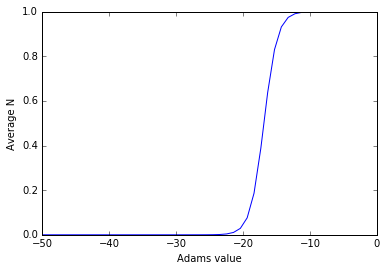

In [99]:
F = -10
B = np.linspace(-50,-0,50) 
N = N_onesite(B,F)

plt.plot(B,N)
plt.xlabel('Adams value')
plt.ylabel('Average N')
plt.show()

In [100]:
print 'Total analytical free energy = {0} kcal/mol'.format(F)
print 'Free energy estimated with GCI = {0} kcal/mol'.format(gci(B,N))

Total analytical free energy = -10 kcal/mol
Free energy estimated with GCI = -10.0000000051 kcal/mol


## Two sites

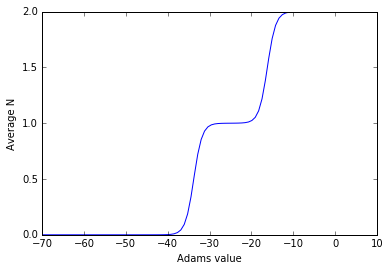

In [101]:
F1 = -20
F2 = -10
B = np.linspace(-70,10,100)
N = N_twosite(B,F1,F2)

plt.plot(B,N)
plt.xlabel('Adams value')
plt.ylabel('Average N')
plt.show()

In [69]:
print 'Total analytical free energy = {0} kcal/mol'.format(F1+F2)
print 'Free energy estimated with GCI = {0} kcal/mol'.format(gci(B,N))

Total analytical free energy = -40 kcal/mol
Free energy estimated with GCI = -39.9999998513 kcal/mol


## Three site

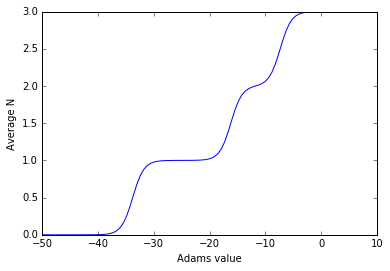

In [73]:
F1 = -20
F2 = -10
F3 = -5
B = np.linspace(-50,10,100)
N = N_threesite(B,F1,F2,F3)

plt.plot(B,N)
plt.xlabel('Adams value')
plt.ylabel('Average N')
plt.show()

In [74]:
print 'Total analytical free energy = {0} kcal/mol'.format(F1+F2+F3)
print 'Free energy estimated with GCI = {0} kcal/mol'.format(gci(B,N))

Total analytical free energy = -35 kcal/mol
Free energy estimated with GCI = -34.9999974843 kcal/mol


## Four site

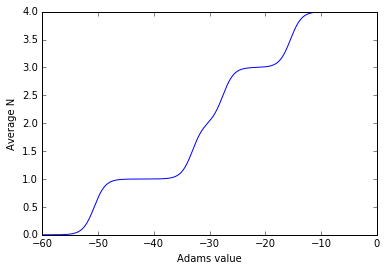

In [98]:
F1 = -30
F2 = -20
F3 = -17
F4 = -10
B = np.linspace(-60,0,1000)
#N = N_nsite(B,4,[F1,F2,F3,F4])
#N_pred = interpolate.interp1d(B, N, kind='cubic')
plt.plot(B,N)
#plt.plot(B,N_pred(B))
plt.xlabel('Adams value')
plt.ylabel('Average N')
plt.show()

In [95]:
print 'Total analytical free energy = {0} kcal/mol'.format(F1+F2+F3+F4)
print 'Free energy estimated with GCI = {0} kcal/mol'.format(gci(B,N))

Total analytical free energy = -94 kcal/mol
Free energy estimated with GCI = -93.9968083123 kcal/mol
